In [1]:
from keras.applications.xception import Xception, preprocess_input, decode_predictions
from keras.preprocessing import image
import matplotlib.pyplot as plt
import keras.backend as K
import numpy as np
import cv2


import numpy as np
import cv2
import matplotlib.pyplot as plt

from keras.models import Model

import keras.applications.xception as xception
from keras.layers import UpSampling2D, Conv2D

Using TensorFlow backend.


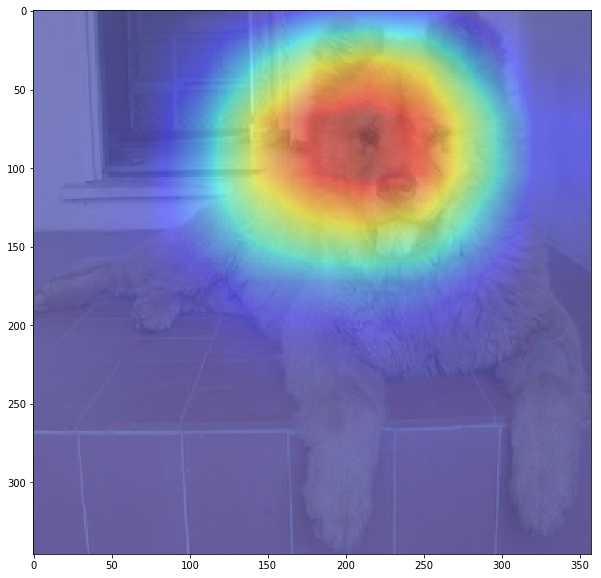

In [5]:
# -*- coding: utf-8 -*-

# Please set an appropriate image file
INPUT_IMG_FILE = "./dog-breeds/chow-chow/14500.jpg"

################################################################
# The following parameters can be changed to other models
# that use global average pooling.
# e.g.) InceptionResnetV2 / NASNetLarge
NETWORK_INPUT_SIZE = 299
MODEL_CLASS = xception.Xception
PREPROCESS_FN = xception.preprocess_input
LAST_CONV_LAYER = "block14_sepconv2_act"
PRED_LAYER = "predictions"
################################################################

# number of imagenet classes
N_CLASSES = 1000


def load_img(fname, input_size, preprocess_fn):
    original_img = cv2.imread(fname)[:, :, ::-1]
    original_size = (original_img.shape[1], original_img.shape[0])
    img = cv2.resize(original_img, (input_size, input_size))
    imgs = np.expand_dims(preprocess_fn(img), axis=0)
    return imgs, original_img, original_size


def get_cam_model(model_class,
                  input_size=224,
                  last_conv_layer="activation_49",
                  pred_layer="fc1000"):
    model = model_class(input_shape=(input_size, input_size, 3), include_top=True)

#     model.summary()
    
    final_params = model.get_layer(pred_layer).get_weights()
    final_params = (final_params[0].reshape(
        1, 1, -1, N_CLASSES), final_params[1])

    last_conv_output = model.get_layer(last_conv_layer).output
    x = UpSampling2D(size=(32, 32), interpolation="bilinear")(
        last_conv_output)
    x = Conv2D(filters=N_CLASSES, kernel_size=(
        1, 1), name="predictions_2")(x)

    cam_model = Model(inputs=model.input,
                      outputs=[model.output, x])
    cam_model.get_layer("predictions_2").set_weights(final_params)
    return cam_model


def postprocess(preds, cams, top_k=1):
    idxes = np.argsort(preds[0])[-top_k:]
    class_activation_map = np.zeros_like(cams[0, :, :, 0])
    for i in idxes:
        class_activation_map += cams[0, :, :, i]
    return class_activation_map


# 1. load image
imgs, original_img, original_size = load_img(INPUT_IMG_FILE,
                                             input_size=NETWORK_INPUT_SIZE,
                                             preprocess_fn=xception.preprocess_input)

# 2. prediction
model = get_cam_model(MODEL_CLASS,
                      NETWORK_INPUT_SIZE,
                      LAST_CONV_LAYER,
                      PRED_LAYER)

preds, cams = model.predict(imgs)

# 4. post processing
class_activation_map = postprocess(preds, cams)

# 5. plot image+cam to original size
plt.figure(figsize = (10, 10))
plt.imshow(original_img, alpha=0.5, aspect='auto')
plt.imshow(cv2.resize(class_activation_map,
                      original_size), cmap='jet', alpha=0.5, aspect='auto')
plt.show()